## CNN para la clasificación de especies de Pokemón aplicada como tarea de entretenimiento

Se presenta una arquitectura de red neuronal híbrida, que cuenta con capas de red convolucionales desde la entrada hasta cierta capa oculta y se conectan con capas Fully Connected en las últimas capas ocultas, junto con la capa de salida para realizar una clasificación de diferentes especies de Pokemón presentes en dicha animación.

La presente aplicación tiene un sentido netamente de entretenimiento, ya que este tipo de desarrollos no son aplicables a tareas de la vida común, tales como desarrollos médicos, o de ingeniería. Pero se consideró una oportunidad divertida para solucionar este caso de clasificación, al ser esta una serie animada muy vista por una gran población mundial.

In [9]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [10]:
data_dir_train = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/DataSet/Train"
data_dir_test = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/DataSet/Test"

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# how many samples per batch to load
num_workers = 0
batch_size = 4
# percentage of training set to use as validation
valid_size = 0.3

image_size = 128

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.ImageFolder(data_dir_train, transform=transform)
test_data = datasets.ImageFolder(data_dir_test, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['Abra', 'Arbok', 'Chansey', 'Fearow', 'Geodude', 'Growlithe', 'Jynx', 'Primeape', 'Sandslash', 'Venomoth']

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [12]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

imgs, masks = next(iter(test_loader))
print(imgs.shape, masks.shape)
print(len(test_loader))

for i, (x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)
    if i==23: break

print(max(train_idx))
print(indices)
print(len(train_data))

torch.Size([4, 3, 128, 128]) torch.Size([4])
torch.Size([4, 3, 128, 128]) torch.Size([4])
23
0 torch.Size([4, 3, 128, 128]) torch.Size([4])
1 torch.Size([4, 3, 128, 128]) torch.Size([4])
2 torch.Size([4, 3, 128, 128]) torch.Size([4])
3 torch.Size([4, 3, 128, 128]) torch.Size([4])
4 torch.Size([4, 3, 128, 128]) torch.Size([4])
5 torch.Size([4, 3, 128, 128]) torch.Size([4])
6 torch.Size([4, 3, 128, 128]) torch.Size([4])
7 torch.Size([4, 3, 128, 128]) torch.Size([4])
8 torch.Size([4, 3, 128, 128]) torch.Size([4])
9 torch.Size([4, 3, 128, 128]) torch.Size([4])
10 torch.Size([4, 3, 128, 128]) torch.Size([4])
11 torch.Size([4, 3, 128, 128]) torch.Size([4])
12 torch.Size([4, 3, 128, 128]) torch.Size([4])
13 torch.Size([4, 3, 128, 128]) torch.Size([4])
14 torch.Size([4, 3, 128, 128]) torch.Size([4])
15 torch.Size([4, 3, 128, 128]) torch.Size([4])
16 torch.Size([4, 3, 128, 128]) torch.Size([4])
17 torch.Size([4, 3, 128, 128]) torch.Size([4])
18 torch.Size([4, 3, 128, 128]) torch.Size([4])
19 to

c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


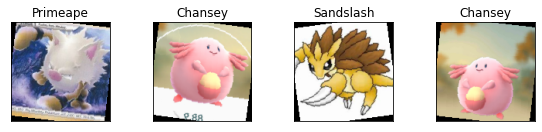

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(4):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture

class Convolution(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv = nn.Sequential(
                           nn.Conv2d(channels_in, channels_out//2, 3, padding=1),
                           nn.BatchNorm2d(channels_out//2),
                           nn.ReLU(),

                           nn.Conv2d(channels_out//2, channels_out, 3, padding=1),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU()
                           )
    def forward(self, x):
        return self.conv(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3,128,128
        self.conv1 = nn.Sequential(
                        Convolution(3,16),
                        nn.MaxPool2d(2 ,2)
        )
        # 16,64,64
        self.conv2 = nn.Sequential(
                        Convolution(16,32),
                        nn.MaxPool2d(2 ,2)
        )
        # 32,32,32
        self.conv3 = nn.Sequential(
                        Convolution(32,64),
                        nn.MaxPool2d(2 ,2)
        )
        # 64,16,16
        self.conv4 = nn.Sequential(
                        Convolution(64,128),
                        nn.MaxPool2d(2 ,2)
        )

        # 128,8,8
        self.conv5 = nn.Sequential(
                        Convolution(128,256),
                        nn.MaxPool2d(2 ,2)
        )

        # 256,4,4
        self.conv6 = nn.Sequential(
                        Convolution(256,512),
                        nn.MaxPool2d(2 ,2)
        )
        #512,2,2
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv1(x) #16X16X16
        x = self.conv2(x) #32X8X8
        x = self.conv3(x) #64X4X4
        x = self.conv4(x) #16X16X16
        x = self.conv5(x) #32X8X8
        x = self.conv6(x) #64X4X4
        # flatten image input
        x = x.view(-1, 512 * 2 * 2)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc_out(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Sequential(
    (0): Convolution(
      (conv): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Convolution(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [15]:
from torchsummary import summary

summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           1,168
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
       Convolution-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           2,320
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 32, 64, 64]           4,640
      BatchNorm2d-13           [-1, 32, 64, 64]              64
             ReLU-14           [-1, 32,

In [16]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.295041 	Validation Loss: 2.399428
Validation loss decreased (inf --> 2.399428).  Saving model ...
Epoch: 2 	Training Loss: 2.284952 	Validation Loss: 2.309074
Validation loss decreased (2.399428 --> 2.309074).  Saving model ...
Epoch: 3 	Training Loss: 2.229521 	Validation Loss: 3.072576
Epoch: 4 	Training Loss: 2.209800 	Validation Loss: 2.231509
Validation loss decreased (2.309074 --> 2.231509).  Saving model ...
Epoch: 5 	Training Loss: 2.178289 	Validation Loss: 2.190216
Validation loss decreased (2.231509 --> 2.190216).  Saving model ...
Epoch: 6 	Training Loss: 2.159237 	Validation Loss: 2.117859
Validation loss decreased (2.190216 --> 2.117859).  Saving model ...
Epoch: 7 	Training Loss: 2.173171 	Validation Loss: 2.198526
Epoch: 8 	Training Loss: 2.112437 	Validation Loss: 1.960098
Validation loss decreased (2.117859 --> 1.960098).  Saving model ...
Epoch: 9 	Training Loss: 2.166963 	Validation Loss: 2.049496
Epoch: 10 	Training Loss: 2.084236 	Valida

In [17]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

In [33]:
print(class_correct)
print(correct)
print(output.shape)
print(pred)
print(correct_tensor)
print(np.squeeze(correct_tensor.numpy()))


[0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 9.0, 1.0, 6.0, 5.0]
True
torch.Size([1, 10])
tensor([9])
tensor([True])
True


In [19]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    if batch_idx != 22:
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.683160

Test Accuracy of  Abra:  0% ( 0/ 7)
Test Accuracy of Arbok: 37% ( 3/ 8)
Test Accuracy of Chansey:  0% ( 0/ 9)
Test Accuracy of Fearow: 20% ( 2/10)
Test Accuracy of Geodude:  0% ( 0/ 7)
Test Accuracy of Growlithe: 22% ( 2/ 9)
Test Accuracy of  Jynx: 90% ( 9/10)
Test Accuracy of Primeape: 10% ( 1/10)
Test Accuracy of Sandslash: 55% ( 5/ 9)
Test Accuracy of Venomoth: 55% ( 5/ 9)

Test Accuracy (Overall): 30% (27/88)


c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


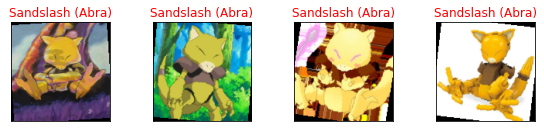

In [55]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))